In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widjets
%matplotlib inline

import numpy as np
import collections

from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt

import os
import shutil
import cv2
from pathlib import Path
from copy import deepcopy
import random

from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from time import time
from tqdm import tqdm, tqdm_notebook

from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn import metrics
import json

from scipy.stats import multivariate_normal

In [6]:
from typing import Callable, List, Tuple

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import catalyst
from catalyst import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

np.random.seed(42)
random.seed(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.set_printoptions(precision=10)

torch: 1.7.0, catalyst: 20.08.2


In [10]:
class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        transforms=None
    ) -> None:
        self.images = images
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        
        result = {"image": image}
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["filename"] = image_path.name

        return result
    
import albumentations as albu
from albumentations.pytorch import ToTensor

def train_transforms(image_size=24):
    return albu.Compose([albu.Resize(image_size, image_size, p=1),
                         albu.HorizontalFlip(),
                         albu.Normalize(), 
                         ToTensor()])

def eval_transforms(image_size=24):
    return albu.Compose([albu.Resize(image_size, image_size, p=1),
                         albu.Normalize(), 
                         ToTensor()])

# Model architecture

In [11]:
class sCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(sCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool1 = nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=0, bias=False)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool2 = nn.Conv2d(64, 64, kernel_size=2, stride=2, padding=0,bias=False)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool3 = nn.Conv2d(128, 128, kernel_size=2, stride=2, padding=0,bias=False)

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.relu = nn.ReLU(inplace=True)

        self.fc = nn.Linear(128, num_classes, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)
        
        x = self.avgpool(x)

        emb = torch.flatten(x, 1)
        #x = self.fc(emb)
        #result = {'embedding':emb, 'logit':x}
        return emb

# Load train Data

In [9]:
ROOT = Path("EyesDataset/")
ALL_IMAGES = sorted(ROOT.glob("*.jpg"))
print(f'found {len(ALL_IMAGES)} images')

train_dataset = SegmentationDataset(images=ALL_IMAGES,transforms=train_transforms())
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=0,drop_last=True)

found 3799 images


# Train the model

In [19]:
# https://medium.com/swlh/neural-networks-intuitions-10-byol-paper-explanation-f8b1d6e83b1c
# https://github.com/lucidrains/byol-pytorch

model = sCNN(num_classes=1).cuda().train()

from byol_pytorch import BYOL
from torchvision import models

#resnet = models.resnet50(pretrained=True)

learner = BYOL(
    model,
    image_size = 24,
    hidden_layer = 'avgpool'
)

opt = torch.optim.Adam(learner.parameters(), lr=3e-4)


for ep in tqdm_notebook(range(100)):
    for batch in train_loader:
        images = batch['image']
        loss = learner(images.cuda())
        opt.zero_grad()
        loss.backward()
        opt.step()
        learner.update_moving_average() # update moving average of target encoder
    # save your improved network
    torch.save(model.state_dict(), './sCNN_BYOL.pt')

c:\python37\lib\site-packages\ipykernel_launcher.py:17: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



# Save traced model

In [12]:
model = sCNN(num_classes=1).cuda()
model.load_state_dict(torch.load('./sCNN_BYOL.pt'))
model.eval()
print()

In [14]:
batch = next(iter(train_loader))['image'].cuda()
traced = torch.jit.trace(model, batch)
traced.save('traced_cnn.zip')

# Eval model

In [15]:
loaded_model = torch.jit.load('traced_cnn.zip')

In [18]:
from catalyst.dl import SupervisedRunner
runner = SupervisedRunner(device=utils.get_device(), input_key="image")

opened_IMAGES = sorted(Path("test/opened/").glob("*.jpg"))
print(f'found {len(opened_IMAGES)} opened eyes')

closed_IMAGES = sorted(Path("test/closed/").glob("*.jpg"))
print(f'found {len(closed_IMAGES)} closed eyes')

opened_dataset = SegmentationDataset(images=opened_IMAGES,transforms=eval_transforms())
closed_dataset = SegmentationDataset(images=closed_IMAGES,transforms=eval_transforms())
test_dataset = opened_dataset+closed_dataset+train_dataset
all_loader = DataLoader(test_dataset,batch_size=32,shuffle=False,num_workers=0,drop_last=False)

predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    runner.predict_loader(model=loaded_model, loader=all_loader)
)))
print(predictions.shape)

found 100 opened eyes
found 101 closed eyes
(4000, 128)


# UMAP

In [19]:
colors = []
true_labels = []

for _ in opened_dataset:
    colors.append((0,0,1))
    true_labels.append(1)
for _ in closed_dataset:
    colors.append((1,0,0))
    true_labels.append(0)
true_labels = np.array(true_labels)

for _ in train_dataset:
    colors.append((0,1,0))
print(len(colors))

4000


(4000, 128)


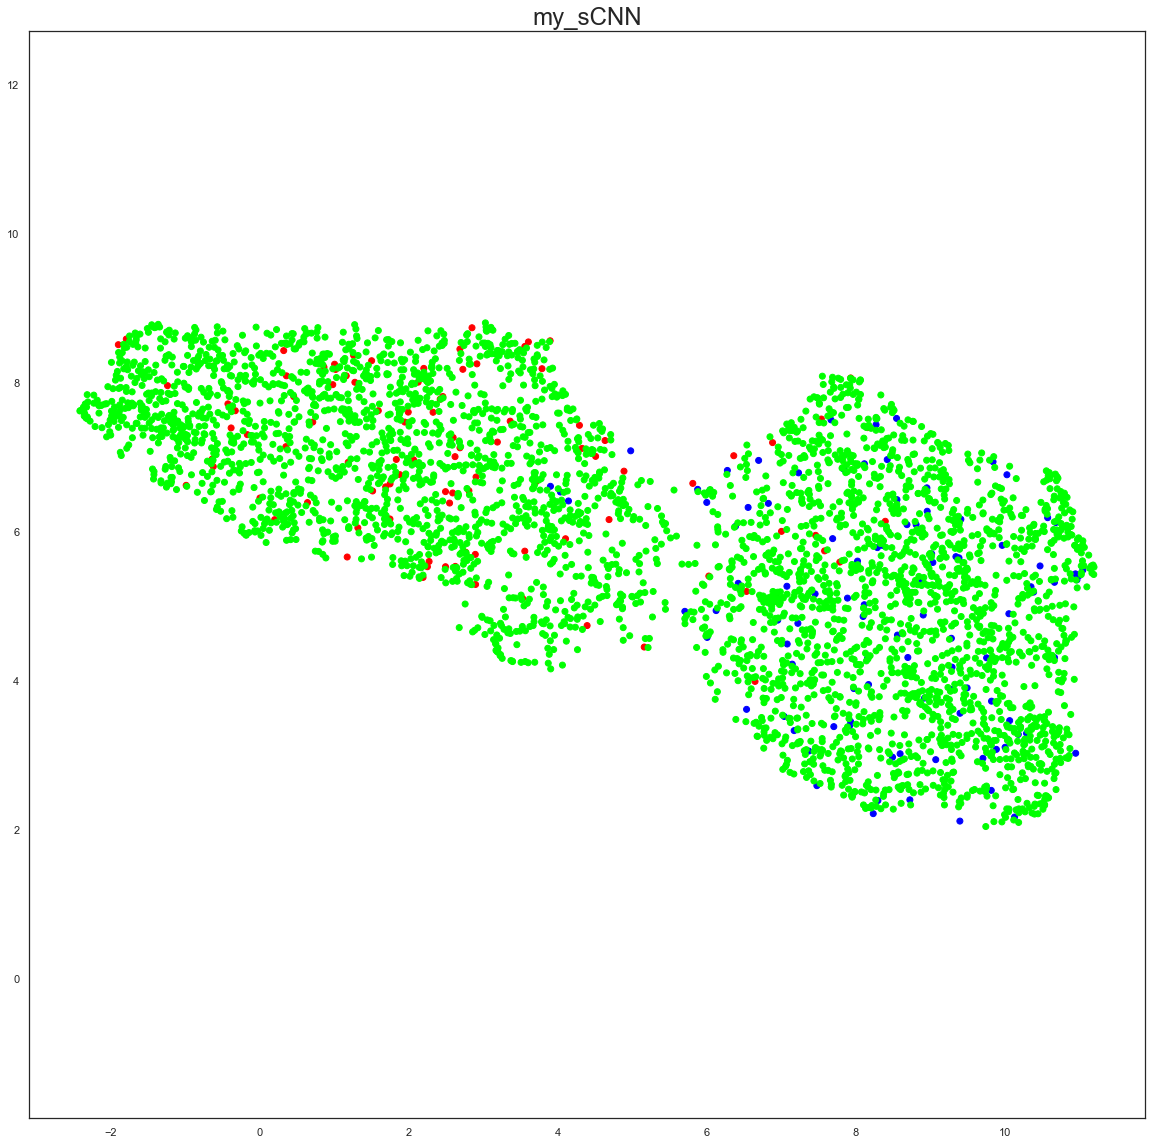

In [20]:
import umap
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

def get_plt(embeddings, name='net name'):
    print(embeddings.shape)
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(embeddings)
    plt.figure(figsize=(20,20))
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=colors)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(name, fontsize=24)
    plt.savefig(name+'.png')
get_plt(predictions,'my_sCNN')

# Clustering

In [21]:
# Find K clusters from data matrix X (n_examples x n_features)

# spherical k-means
from spherecluster import SphericalKMeans
skm = SphericalKMeans(n_clusters=2)
skm.fit(predictions) 

SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2,
        n_init=10, n_jobs=1, normalize=True, random_state=None, tol=0.0001,
        verbose=0)

In [22]:
from sklearn.metrics import accuracy_score
test_labels = skm.labels_[:len(true_labels)]
accuracy_score(test_labels, true_labels) 

0.8805970149253731

In [24]:
skm.labels_[:len(true_labels)] # 0-closed, 1-opened

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1])

In [25]:
np.save('clusters.npy', skm.cluster_centers_)

# Task Function

In [14]:
import numpy as np
import torch
import cv2

import albumentations as albu
from albumentations.pytorch import ToTensor


def eval_transforms(image_size=24):
    return albu.Compose([albu.Resize(image_size, image_size, p=1),
                         albu.Normalize(),
                         ToTensor()])

class Estimator():
    def __init__(
        self,
        loaded_model='traced_cnn.zip',
        clusters = 'clusters.npy'
    ) -> None:
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.loaded_model = torch.jit.load(loaded_model).to(self.device).eval()
        self.clusters = np.load(clusters)
        
        
    def openEyeCheck(self, inpIm):
        image = cv2.imread(inpIm)

        result = {"image": image}
        result = eval_transforms()(**result)
        with torch.no_grad():
            inputs = result['image'].unsqueeze(0).to(self.device)
            emb = self.loaded_model(inputs).cpu().numpy().squeeze()

        opened_similarity =  np.dot(emb, self.clusters[1])/(np.linalg.norm(emb)*np.linalg.norm(self.clusters[1]))
        closed_similarity = np.dot(emb, self.clusters[0])/(np.linalg.norm(emb)*np.linalg.norm(self.clusters[0]))

        softmax_opened = np.exp(opened_similarity)/(np.exp(opened_similarity)+np.exp(closed_similarity))
        #softmax_closed = np.exp(closed_similarity)/(np.exp(opened_similarity)+np.exp(closed_similarity))
        return softmax_opened
    

In [15]:
estim = Estimator()

In [16]:
inpIm = r'EyesDataset/000291.jpg'
estim.openEyeCheck(inpIm)

0.62454844